In [29]:
import sys
import os
import time
import logging
import datetime
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import requests
import pandas_gbq
from dreams_core.googlecloud import GoogleCloud as dgc
from dreams_core import core as dc
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# load dotenv
load_dotenv()

# configure logger
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s [%(name)s.%(funcName)s:%(lineno)d] %(message)s',
    datefmt='%d/%b/%Y %H:%M:%S'
    )
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

## import local files if necessary
# sys.path.append('../GitHub/core-functions/src/dreams_core')
# import googlecloud as dgc2
# importlib.reload(dgc2)

# sys.path.append('../GitHub/etl-pipelines/coin_wallet_metrics')
# import coin_wallet_met?rics as wm
# importlib.reload(wm)

# production-ready code

In [11]:
query_sql = '''
    select 'BTC' as symbol,* from analytics.bitcoin_prices
    '''
prices_df_full_btc = dgc().run_sql(query_sql)
print(prices_df_full_btc.info())
prices_df_full_btc.head()

[30/Aug/2024 17:11:49] INFO [dreams_core.googlecloud.run_sql:91] BigQuery query completed.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4055 entries, 0 to 4054
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   symbol      4055 non-null   object             
 1   date        4055 non-null   datetime64[ns, UTC]
 2   price       4055 non-null   float64            
 3   market_cap  4054 non-null   float64            
 4   volume      4055 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(3), object(1)
memory usage: 158.5+ KB
None


,symbol,date,price,market_cap,volume
0,BTC,2013-04-28 00:00:00+00:00,135.30,1.500518e+09,0.0
1,BTC,2013-04-29 00:00:00+00:00,141.96,1.575032e+09,0.0
2,BTC,2013-04-30 00:00:00+00:00,135.30,1.501657e+09,0.0
3,BTC,2013-05-01 00:00:00+00:00,117.00,1.298952e+09,0.0
4,BTC,2013-05-02 00:00:00+00:00,103.43,1.148668e+09,0.0


In [76]:
query_sql = '''
    with filter as (
    select cmd.coin_id
    ,count(date) as records
    from core.coin_market_data cmd  
    group by 1
    )

    select c.symbol
    ,cmd.date
    ,cmd.price
    ,cmd.market_cap
    ,cmd.volume
    from core.coins c
    join core.coin_market_data cmd on cmd.coin_id = c.coin_id
    join filter f on f.coin_id = cmd.coin_id
    where f.records > 360
    '''
prices_df_full_alts = dgc().run_sql(query_sql)
print(prices_df_full_alts.info())
prices_df_full_alts.head()

[30/Aug/2024 23:33:52] INFO [dreams_core.googlecloud.run_sql:91] BigQuery query completed.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60792 entries, 0 to 60791
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   symbol      60792 non-null  object        
 1   date        60792 non-null  datetime64[ns]
 2   price       60792 non-null  object        
 3   market_cap  60331 non-null  Int64         
 4   volume      60792 non-null  Int64         
dtypes: Int64(2), datetime64[ns](1), object(2)
memory usage: 2.4+ MB
None


,symbol,date,price,market_cap,volume
0,$STATS,2024-02-02,0.07785835321751190300000000000000000000,<NA>,2899
1,NRG,2024-02-02,0.12518103731116181000000000000000000000,8746592,235997
2,QI,2024-02-02,0.01568692711731965400000000000000000000,67185250,2798887
3,LAI,2024-02-02,0.01044163027262970200000000000000000000,3327369,1634749
4,AQTIS,2024-02-02,0.01019395843422826900000000000000000000,20336803,83675


# code drafting workspace

In [194]:
def classify_price_periods(prices_df_full, params):
    """
    Classifies price periods as bullish, bearish, or consolidation based on provided thresholds,
    using a rolling average price to smooth out short-term spikes and avoid misclassification.

    Parameters:
    prices_df_full (pd.DataFrame): Full DataFrame containing price data.
    params (dict): Dictionary containing parameters for classification:
        - cutoff_date (str): The cutoff date after which records will be considered.
        - period_min_duration (int): The minimum length of a bullish or bearish period.
        - bull_threshold (float): The minimum percentage change to classify a period as bullish.
        - bear_threshold (float): The minimum percentage change to classify a period as bearish.
        - rolling_window_size (int): The window size for the rolling average to smooth the data.

    Returns:
    pd.DataFrame: DataFrame with classified periods.
    """
    # Unpack parameters
    cutoff_date = params.get('cutoff_date', '2014-01-01')
    period_min_duration = params.get('period_min_duration', 30)
    bull_threshold = params.get('bull_threshold', 0.5)
    bear_threshold = params.get('bear_threshold', -0.4)
    rolling_window_size = params.get('rolling_window_size', 5) 

    # 1. Filter and prepare data
    prices_df = prices_df_full[prices_df_full['date'] >= cutoff_date].copy()

    prices_df['date'] = pd.to_datetime(prices_df['date'])
    prices_df.sort_values('date', inplace=True)
    prices_df.reset_index(drop=True, inplace=True)

    # 2. Identify local price maxima and minima
    n = period_min_duration

    prices_df['local_max'] = prices_df.iloc[argrelextrema(prices_df['price'].values, comparator=lambda x, y: x > y, order=n)[0]].date
    prices_df['local_min'] = prices_df.iloc[argrelextrema(prices_df['price'].values, comparator=lambda x, y: x < y, order=n)[0]].date

    prices_df['local_max'] = prices_df['date'].isin(prices_df['local_max'])
    prices_df['local_min'] = prices_df['date'].isin(prices_df['local_min'])

    # 3. Calculate the rolling average price
    prices_df['rolling_price'] = prices_df['price'].rolling(window=rolling_window_size, min_periods=1).mean()

    # 4. Calculate the % change between local min/max and the price n days prior using the rolling price
    prices_df['rolling_price_n_days_prior'] = prices_df['rolling_price'].shift(n)
    prices_df['pct_change_from_prior'] = ((prices_df['rolling_price'] - prices_df['rolling_price_n_days_prior']) / prices_df['rolling_price_n_days_prior'])

    # 5. Classify periods
    prices_df['period'] = None

    for i in range(len(prices_df)):
        if prices_df['local_max'].iloc[i] and prices_df['pct_change_from_prior'].iloc[i] > bull_threshold:
            start_idx = max(0, i - n)
            prices_df.loc[start_idx:i, 'period'] = 'bullish'

            # Additional check for bearish classification n days after local_max
            end_idx = min(len(prices_df) - 1, i + n)  # Ensure the end index does not go out of bounds
            pct_change_after_max = (prices_df['rolling_price'].iloc[end_idx] - prices_df['rolling_price'].iloc[i]) / prices_df['rolling_price'].iloc[i]

            if pct_change_after_max < bear_threshold:
                prices_df.loc[i+1:end_idx, 'period'] = 'bearish'

    for i in range(len(prices_df)):
        if prices_df['local_min'].iloc[i] and prices_df['pct_change_from_prior'].iloc[i] < bear_threshold:
            start_idx = max(0, i - n)
            prices_df.loc[start_idx:i, 'period'] = prices_df.loc[start_idx:i, 'period'].replace({None: 'bearish', 'consolidation': 'bearish'})

    prices_df['period'].fillna('consolidation', inplace=True)

    return prices_df


def graph_price_action(prices_df):
    """
    Graph the price action of a given DataFrame with color-coded periods.

    Parameters:
    prices_df (pd.DataFrame): The DataFrame containing date, price, and period data. 
                              Assumes 'date', 'price', and 'period' columns exist in the DataFrame.

    Returns:
    None
    """
    # Set colors for different periods
    colors = {'bullish': 'green', 'bearish': 'red', 'consolidation': '#D3D3D3'}

    # Map the period to colors
    prices_df['color'] = prices_df['period'].map(colors)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(21, 10))

    # Plot the price data with color coding based on the period
    ax.plot(prices_df['date'], prices_df['price'], color='blue', label='_nolegend_')

    # Apply color to line segments based on the period
    for i in range(len(prices_df) - 1):
        ax.plot(prices_df['date'].iloc[i-1:i+1], prices_df['price'].iloc[i-1:i+1], color=prices_df['color'].iloc[i])

    # # Set the y-axis to log scale
    # ax.set_yscale('log')

    # Add labels and title
    symbol = prices_df.reset_index(drop=True)['symbol'][0]

    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.set_title(f'{symbol} Price with Periods Highlighted')

    # Add a legend
    handles = [plt.Line2D([0], [0], color=color, label=label) for label, color in colors.items()]
    ax.legend(handles=handles)

    # Show the plot
    plt.show()



In [128]:
# i = 0
s = prices_df_full_alts['symbol'].unique()[i]
prices_df_full = prices_df_full_alts[prices_df_full_alts['symbol']==s]
print(s)
i+=1

AQTIS


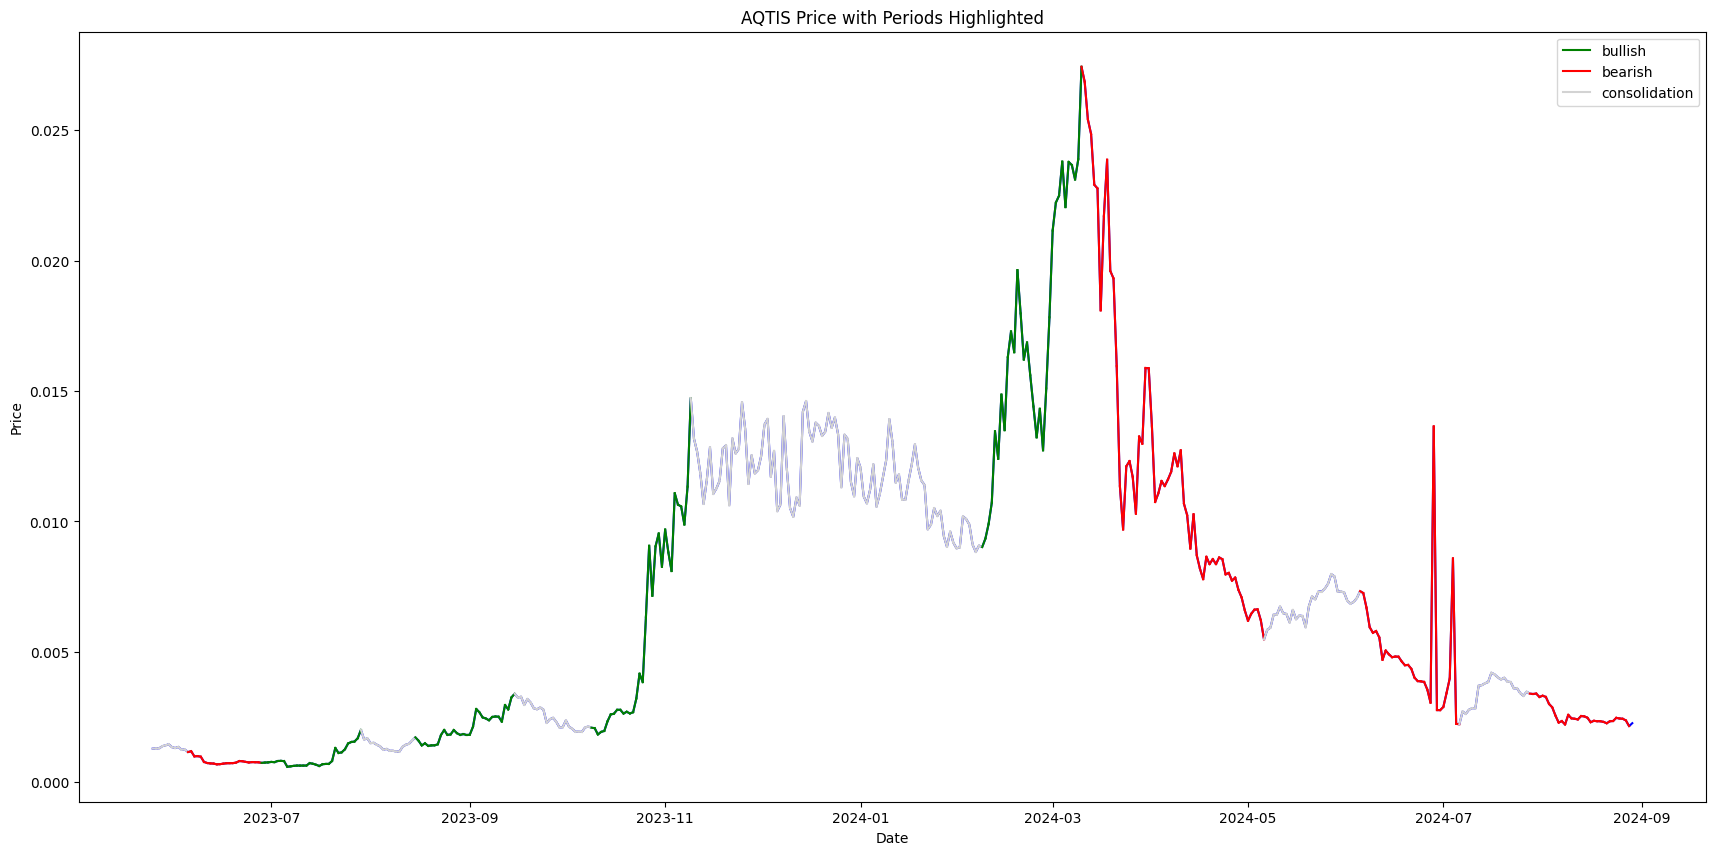

In [195]:
params = {
    'cutoff_date': '2014-01-01',
    'period_min_duration': 30,
    'bull_threshold': 0.5,
    'bear_threshold': -0.3,
    'rolling_window_size': 3
}

prices_df = classify_price_periods(prices_df_full, params)
graph_price_action(prices_df)

In [191]:
pd.set_option('display.max_rows', 100)

prices_df[(prices_df['date'] >= '2023-11-01') & (prices_df['date'] <= '2024-01-01')]
# prices_df[(prices_df['date'] >= '2024-03-01') & (prices_df['date'] <= '2024-04-01')]

,symbol,date,price,market_cap,volume,local_max,local_min,rolling_price,rolling_price_n_days_prior,pct_change_from_prior,period,color
160,AQTIS,2023-11-01,0.00968704444128657900000000000000000000,19119603,175166,False,False,0.009162,0.002202,3.161526,bullish,green
161,AQTIS,2023-11-02,0.00881367444751381470000000000000000000,17548786,100629,False,False,0.008921,0.002182,3.088928,bullish,green
162,AQTIS,2023-11-03,0.00809800791547064280000000000000000000,16155444,160413,False,False,0.008866,0.002037,3.351576,bullish,green
163,AQTIS,2023-11-04,0.01107853628602593400000000000000000000,21923395,416842,False,False,0.009330,0.001974,3.725763,bullish,green
164,AQTIS,2023-11-05,0.01064303730922907900000000000000000000,21250357,325231,False,False,0.009940,0.001934,4.138909,bullish,green
165,AQTIS,2023-11-06,0.01057323313841704700000000000000000000,21093494,159657,False,False,0.010765,0.001989,4.412093,bullish,green
166,AQTIS,2023-11-07,0.00988287759365378410000000000000000000,19692400,210955,False,False,0.010366,0.002055,4.044377,bullish,green
167,AQTIS,2023-11-08,0.01133331890380190300000000000000000000,22609857,144256,False,False,0.010596,0.002109,4.024763,bullish,green
168,AQTIS,2023-11-09,0.01472956844647342600000000000000000000,29418116,692165,True,False,0.011982,0.002100,4.705617,bullish,green
169,AQTIS,2023-11-10,0.01317174706335157700000000000000000000,26277503,267537,False,False,0.013078,0.001999,5.543793,consolidation,#D3D3D3


In [58]:
n = 14
bull_threshold = 0.3
bear_threshold = -0.2


# Identify local maxima and minima within n days on either side of the date
df['local_max'] = df.iloc[argrelextrema(df['price'].values, comparator=lambda x, y: x > y, order=n)[0]].date
df['local_min'] = df.iloc[argrelextrema(df['price'].values, comparator=lambda x, y: x < y, order=n)[0]].date

# Merging results with original DataFrame
df['local_max'] = df['date'].isin(df['local_max'])
df['local_min'] = df['date'].isin(df['local_min'])

# Calculate the % change between local min/max and the price n days prior
df['price_n_days_prior'] = df['price'].shift(n)
df['pct_change_from_prior'] = ((df['price'] - df['price_n_days_prior']) / df['price_n_days_prior'])

df.reset_index(inplace=True,drop=True)
df

,level_0,index,symbol,date,price,market_cap,volume,daily_pct_change,rolling_mean_long,local_max,local_min,price_n_days_prior,pct_change_from_prior,period
0,0,5302,TURBO,2023-05-25,0.00036184493623891327000000000000000000,25017136,5413165,NaN,NaN,False,False,None,NaN,None
1,1,37876,TURBO,2023-05-26,0.00040937514350454323000000000000000000,28265084,6450141,0.131355181475435831613407465,NaN,True,False,None,NaN,None
2,2,5436,TURBO,2023-05-27,0.00034023165711377488000000000000000000,23545867,6378149,-0.1689000602206836189589111767,NaN,False,False,None,NaN,None
3,3,21029,TURBO,2023-05-28,0.00033412128894327685000000000000000000,23097214,4784317,-0.0179594345286179454242808355,NaN,False,False,None,NaN,None
4,4,7841,TURBO,2023-05-29,0.00032041406085755515000000000000000000,22141259,4801837,-0.0410247073123459386228582864,NaN,False,False,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,458,33497,TURBO,2024-08-25,0.00481270758800007680000000000000000000,331182703,70898102,0.010357404623738044580071675,0.008010,True,False,0.00447480251203095060000000000000000000,0.07551284666991110156234270243,None
459,459,10860,TURBO,2024-08-26,0.00452578615822404020000000000000000000,312126394,61292480,-0.0596174657466083354696077289,0.014422,False,False,0.00380630642961204620000000000000000000,0.1890230705059987034439762959,None
460,460,20755,TURBO,2024-08-27,0.00408920253493160780000000000000000000,282154974,55461479,-0.0964658090394071554915143680,0.002918,False,False,0.00405214807911290050000000000000000000,0.009144398253782297886490651044,None
461,461,17975,TURBO,2024-08-28,0.00375418809306989890000000000000000000,259182229,58887513,-0.0819265954669354718333837050,-0.006597,False,False,0.00425994507094192010000000000000000000,-0.1187238261173618470698148972,None


In [63]:
# Initialize the 'period' column with None or empty strings
df['period'] = None

# Iterate over the DataFrame to set the 'period' based on bullish conditions
for i in range(len(df)):
    if df['local_max'].iloc[i] and df['pct_change_from_prior'].iloc[i] > bull_threshold:
        # Set the 'period' as 'bullish' for the n days preceding the local_max date and the date itself
        start_idx = max(0, i - n)  # Ensure the start index is not less than 0
        df.loc[start_idx:i, 'period'] = 'bullish'

# Iterate over the DataFrame to set the 'period' based on bearish conditions
for i in range(len(df)):
    if df['local_min'].iloc[i] and df['pct_change_from_prior'].iloc[i] < bear_threshold:
        # Set the 'period' as 'bearish' for the n days preceding the local_min date and the date itself
        start_idx = max(0, i - n)  # Ensure the start index is not less than 0
        df.loc[start_idx:i, 'period'] = 'bearish'

# Fill empty values in the 'period' column with 'consolidation'
df['period'].fillna('consolidation', inplace=True)

# Display the updated DataFrame
df[['date', 'price', 'local_max', 'local_min', 'pct_change_from_prior', 'period']]


,date,price,local_max,local_min,pct_change_from_prior,period
0,2023-05-25,0.00036184493623891327000000000000000000,False,False,NaN,consolidation
1,2023-05-26,0.00040937514350454323000000000000000000,True,False,NaN,consolidation
2,2023-05-27,0.00034023165711377488000000000000000000,False,False,NaN,consolidation
3,2023-05-28,0.00033412128894327685000000000000000000,False,False,NaN,consolidation
4,2023-05-29,0.00032041406085755515000000000000000000,False,False,NaN,bearish
...,...,...,...,...,...,...
458,2024-08-25,0.00481270758800007680000000000000000000,True,False,0.07551284666991110156234270243,consolidation
459,2024-08-26,0.00452578615822404020000000000000000000,False,False,0.1890230705059987034439762959,consolidation
460,2024-08-27,0.00408920253493160780000000000000000000,False,False,0.009144398253782297886490651044,consolidation
461,2024-08-28,0.00375418809306989890000000000000000000,False,False,-0.1187238261173618470698148972,consolidation
